In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]
    


In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']
for col in df.columns:
    print(col)
    # df[col] = pd.to_numeric(df[col])
df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.ffill()

df = df[df.index >= '1987-01-01']


SP_price
dow_jones
gdp
bond_yield
home_price_index
consumer_price_index
eur
jpy


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
df.dtypes

SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()


In [9]:

df.reset_index(inplace=True)  # Move the index back to a column
df.head(10)


,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_price_ln,SP_MA_30,SP_MA_100,SP_MA_200
0,1987-01-01,242.712498,1895.95,4722.156,7.23,63.733,111.4,0.9107,157.47,5.491878,NaN,NaN,NaN
1,1987-01-02,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,5.498438,NaN,NaN,NaN
2,1987-01-03,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,5.498438,NaN,NaN,NaN
3,1987-01-04,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,5.498438,NaN,NaN,NaN
4,1987-01-05,249.415001,1971.32,4722.156,7.08,63.733,111.4,0.9149,159.13,5.519118,NaN,NaN,NaN
5,1987-01-06,252.777500,1974.83,4722.156,7.08,63.733,111.4,0.9107,158.75,5.532510,NaN,NaN,NaN
6,1987-01-07,254.119999,1993.95,4722.156,7.05,63.733,111.4,0.9162,157.75,5.537807,NaN,NaN,NaN
7,1987-01-08,256.222500,2002.25,4722.156,7.04,63.733,111.4,0.9152,158.21,5.546046,NaN,NaN,NaN
8,1987-01-09,257.825004,2005.91,4722.156,7.01,63.733,111.4,0.9128,158.02,5.552281,NaN,NaN,NaN
9,1987-01-10,257.825004,2005.91,4722.156,7.01,63.733,111.4,0.9128,158.02,5.552281,NaN,NaN,NaN


In [10]:
df_first_of_month = df[df['date'].dt.day == 1]

## Add timeseries features
- For each daily feature, get the last 10 days for that feature

In [11]:
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [12]:
daily_features = ["SP_price_ln", "dow_jones_ln", "gdp_ln", "eur", "jpy", "home_price_index_ln", "consumer_price_index", "bond_yield_ln"]

#################
lookback = 60
forecast = 15
#################
# Store all new columns in a dictionary first
new_cols = {}

# Forecast columns (shift forward)
for f in daily_features:
    new_cols[f + f"+{forecast}"] = df[f].shift(-forecast)

# Lookback columns (shift backward)
for f in daily_features:
    for i in range(1, lookback + 1):
        new_cols[f + f"-{i}"] = df[f].shift(i)

# Combine all at once using pd.concat
df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

# df.iloc[35177:35187]
df_with_wknd = df.copy()
df = df[df['date'].dt.weekday < 5].reset_index(drop=True)
# i = 1
# for col in df.columns:
#     print(i, col)
#     i+=1
# df.shape

In [13]:
df_filtered = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
col =  df.iloc[:, 26:].columns
df_filtered = df_filtered.dropna(subset=col)
X = df_filtered[col]
y = df_filtered[f'SP_price_ln+{forecast}']

model = LinearRegression()
model.fit(X, y)

# print("Intercept:", model.intercept_)
# print("Coefficients:", model.coef_)

# Predict on new data
predictions = model.predict(X)


In [24]:
refined = []
for i in range(len(col)):
    if abs(model.coef_[i]) > 0.075:
        refined.append(col[i])
print(refined)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [15]:
# #############
# lookback = lookback
# forecast = forecast
# ##############

In [16]:
df_model3 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
normalized = df_model3.copy()
scaler = StandardScaler()
y_col = "SP_price_ln"

features = df.iloc[:, 26:]
y = df_model3[y_col]

scaled_array = scaler.fit_transform(features)
normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
normalized[y_col] = y

n = len(normalized)
def adj_r2(R2, p):
    return 1 - (1-R2) * (n-1) / (n-p-1)

mod_3_scores = []
for c in normalized.columns:
    if c == y_col: continue
    model = LinearRegression(fit_intercept=True)
    working_df = normalized.dropna(subset=[y_col, c])
    col = working_df[c].to_numpy().reshape(-1, 1)
    model.fit(col, working_df[y_col])
    score = adj_r2(model.score(col, working_df[y_col]), 1)
    mod_3_scores.append((c, score))

mod_3_scores = sorted(mod_3_scores, key=lambda x: x[1], reverse=True)

mod_3_score = 0
mod_3_cols = []
reg3 = LinearRegression(fit_intercept=True)
for c, _ in mod_3_scores:
    working_df = normalized.dropna(subset=mod_3_cols + [c, y_col])
    X = working_df[mod_3_cols + [c]]
    reg3.fit(X, working_df[y_col])
    score = adj_r2(reg3.score(X, working_df[y_col]), len(mod_3_cols) + 1)
    if score > mod_3_score:
        mod_3_score = score
        mod_3_cols += [c]

final_scaler = StandardScaler()
working_df = df_model3.dropna(subset=mod_3_cols + [y_col])
X3_raw = working_df[mod_3_cols]
X3_scaled = pd.DataFrame(final_scaler.fit_transform(X3_raw), columns=mod_3_cols)
reg3.fit(X3_scaled, working_df[y_col])

LinearRegression()

In [21]:
def plot_predictions(selected_date, forecast=5, window=30):
    selected_date = pd.to_datetime(selected_date)
    
    selected_idx = df[df['date'] == selected_date].index[0]
    
    predicted_prices = []
    valid_indices = []
    
    for offset in range(forecast):
        idx = selected_idx + offset
        X_row = df.iloc[idx]
        X_features = X_row[mod_3_cols].to_frame().T
        X_scaled = pd.DataFrame(final_scaler.transform(X_features), columns=mod_3_cols)
        pred_ln = reg3.predict(X_scaled)[0]
        pred_price = np.exp(pred_ln)
        
        predicted_prices.append(pred_price)
        valid_indices.append(idx)
    
    plot_start = selected_idx - window
    plot_end = selected_idx + forecast + window
    
    plt.figure(figsize=(16, 6))
    
    plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end], label='Actual price', color='blue')
    plt.plot(valid_indices, predicted_prices, 'ro--', label=f'Predicted price for {forecast} days)')
    
    plt.axvline(x=selected_idx, color='green')
    
    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
    plt.xticks(ticks=xticks, labels=xlabels, rotation=45)
    
    plt.title(f"{forecast} days prediction from {selected_date.date()} from past {lookback} days")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.show()

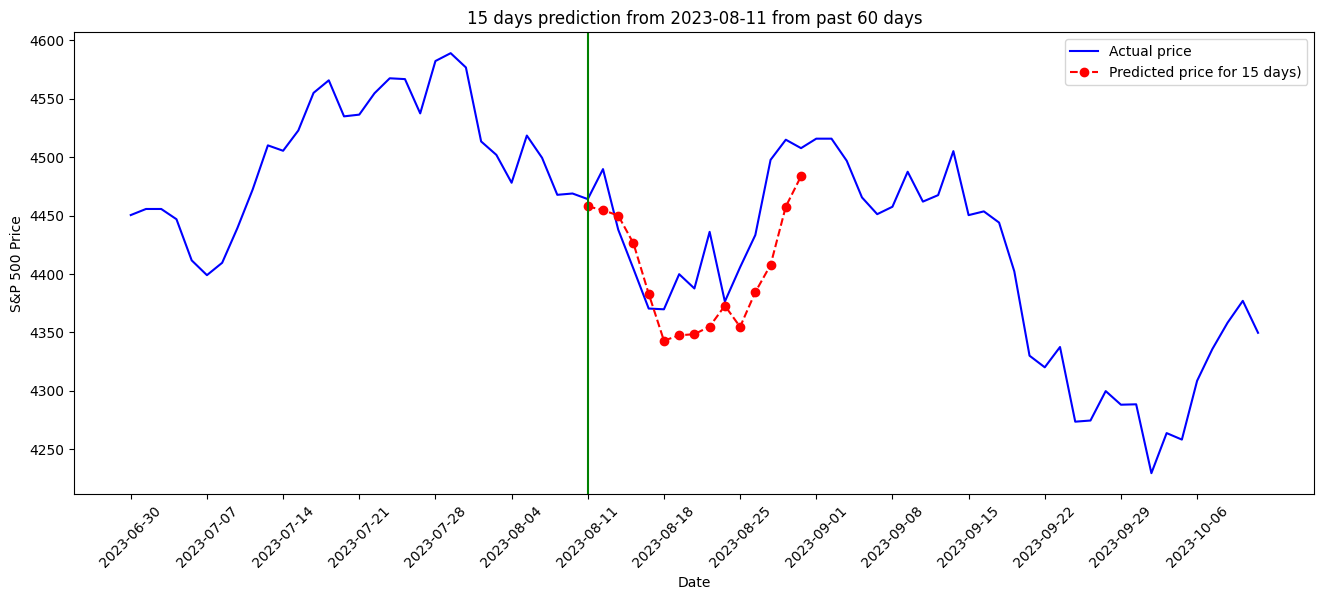

In [22]:
plot_predictions('2023-8-11', forecast)

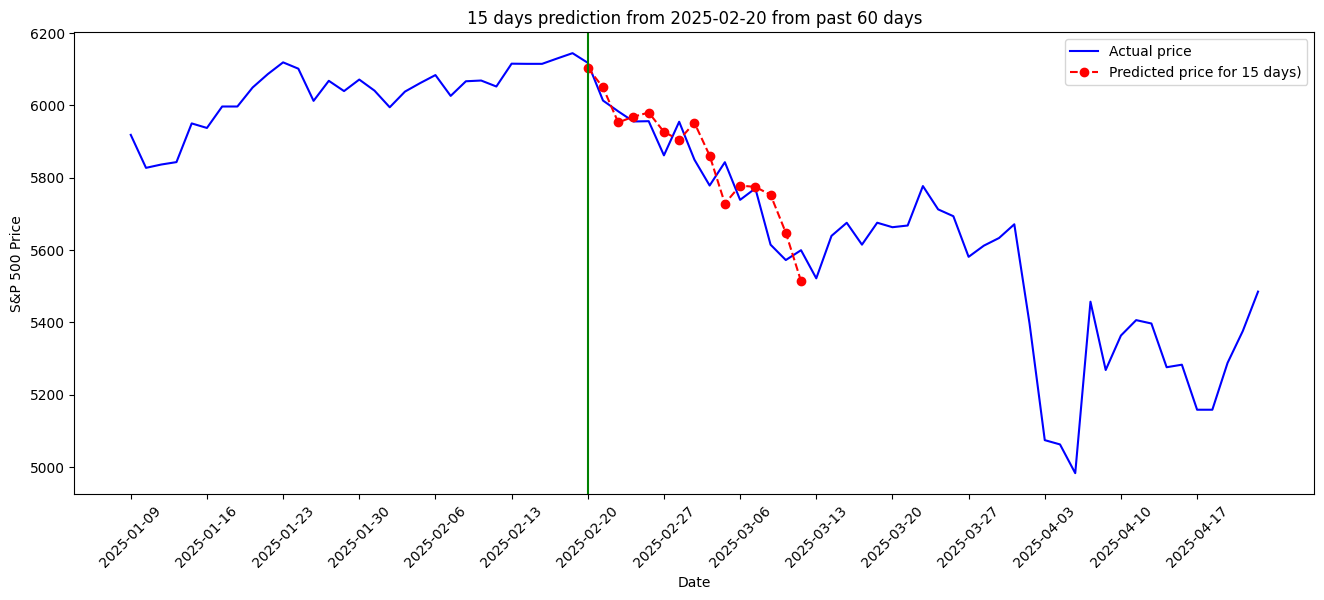

In [23]:
plot_predictions('2025-2-20', forecast)